In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
from pathlib import Path
import itertools
import functools
from collections import namedtuple, Counter, defaultdict
import re
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import read_vocab, PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID, IMAGE_H, IMAGE_W
dataset_name = ("saycam", "childes")[1]
if dataset_name == "saycam":
    from multimodal.multimodal_saycam_data_module import VOCAB_FILENAME
else:
    from multimodal.text_only_data_module import VOCAB_FILENAME
from ngram import NGramModel
from multimodal.utils import map_structure
from analysis_tools.processing import *
from analysis_tools.utils import *
from analysis_tools.sentences_data import *
from analysis_tools.sentences_utils import *
from analysis_tools.checkpoints import *
from analysis_tools.build_data import *
import analysis_tools.plotting as plotting
import textwrap

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


ZORRO_TXT_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/Zorro/sentences/babyberta/")
ZORRO_TXT_FILES = ZORRO_TXT_DIR.glob('*.txt')
TRAIN_MEAN_IMG_FILE = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal/train_mean_img.pt")


# set default settings for plotting; may change for each plot
figsize = (12, 12)
paper_context = sns.plotting_context('paper')
paper_context.update({
    'font.size': 10.,
    'axes.labelsize': 10.,
    'axes.titlesize': 14.,
    'xtick.labelsize': 8.8,
    'ytick.labelsize': 8.8,
    'legend.fontsize': 8.8,
    'legend.title_fontsize': 9.6,
})
unticked_relation_style = sns.axes_style('white')
unticked_relation_style.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
})
font = 'serif'
sns.set_theme(
    #context=paper_context,
    style=unticked_relation_style,
    #palette=sns.color_palette('tab20'),
    font='serif',
    rc={
        'figure.figsize': figsize,
    }
)

np.set_printoptions(suppress=True, precision=2, linewidth=120)
pd.options.display.width = 120

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.
plot_format = 'pdf'
saving_fig = False

if saving_fig:
    def _save_fig(fname, format='png'):
        print(f'saving plot {fname}')
        plt.savefig(f'plots/{fname}.{format}', transparent=True)
        plt.clf()
    plotting.output_fig = functools.partial(_save_fig, format=plot_format)
else:
    plotting.output_fig = lambda fname: plt.show()

output_fig = plotting.output_fig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def sentence_pair_in_vocab(sentence_pair, vocab):
    for sentence in sentence_pair:
        if not all(str(token) in vocab for token in sentence):
            return False
    return True


phenomenon_name_aliases = {
    'agreement_determiner_noun': 'determiner-noun_agreement',
    'agreement_subject_verb'   : 'subject-verb_agreement'   ,
}


def get_data_name_from_paradigm_name(
    paradigm_name,
    sep='-',
    replace_underline_by=' ',
    phenomenon_name_aliases=phenomenon_name_aliases,
):
    partition_of_paradigm_name = paradigm_name.rpartition(sep)
    assert partition_of_paradigm_name[1] == sep
    phenomenon_name, _paradigm_name = partition_of_paradigm_name[0], partition_of_paradigm_name[2]
    phenomenon_name = phenomenon_name_aliases.get(phenomenon_name, phenomenon_name)
    data_name = phenomenon_name, _paradigm_name
    if replace_underline_by is not None:
        data_name = tuple(name.replace('_', replace_underline_by) for name in data_name)
    return data_name

In [3]:
# get my vocab
my_vocab = read_vocab(VOCAB_FILENAME)
my_vocab_size = len(my_vocab)
print(f'{my_vocab_size = }')
word2idx = my_vocab
idx2word = [None] * my_vocab_size
for word, idx in word2idx.items():
    idx2word[idx] = word
idx2word = np.array(idx2word)

# get Zorro data
zorro_data = {}
zorro_vocab = Counter()

for zorro_txt_file in ZORRO_TXT_FILES:
    paradigm_name = zorro_txt_file.stem
    data_name = get_data_name_from_paradigm_name(paradigm_name)
    print(f'processing {paradigm_name} ...', flush=True)

    with open(zorro_txt_file, 'r') as f:
        sentences = pd.Series(tokenize(line.strip() for line in f))

    zorro_data[data_name] = sentences

    zorro_vocab.update(map(str, itertools.chain.from_iterable(sentences)))

# Zorro vocab
zorro_vocab = sorted(
    zorro_vocab.items(),
    key = lambda item: (-item[1], item[0])
)
zorro_vocab_size = len(zorro_vocab)
print(f'{zorro_vocab_size = }')
print('words in zorro vocab:')
for word, freq in zorro_vocab[:100]:
    print(f'{word:10} {freq:6}')

# Zorro vocab compared to my vocab
in_my_vocab_cnt = 0
print('words not in my vocab:')
for word, freq in zorro_vocab:
    if word in my_vocab:
        in_my_vocab_cnt += 1
    else:
        print(word)
print(f'{frac_format(in_my_vocab_cnt, len(zorro_vocab))} in my vocab')

# filter Zorro data
filter_masks = {}

for data_name, sentences in zorro_data.items():
    n_total = 0

    print('out-of-my vocab sentence examples:')
    sentence_pairs = pd.Series(paired(sentences))
    filter_mask = sentence_pairs.map(lambda sentence_pair: sentence_pair_in_vocab(sentence_pair, my_vocab))
    for sentence_pair in sentence_pairs[~filter_mask].iloc[:1]:
        for sentence in sentence_pair:
            print(untokenize(sentence))
        print(
            'OOV tokens:',
            ' '.join(
                str(token)
                for sentence in sentence_pair
                for token in sentence
                if str(token) not in my_vocab
            )
        )

    print(f'{data_name}: {frac_format(filter_mask.sum(), len(filter_mask))}')

    filter_masks[data_name] = filter_mask

my_vocab_size = 2726
processing agreement_determiner_noun-across_1_adjective ...
processing agreement_determiner_noun-between_neighbors ...
processing agreement_subject_verb-across_prepositional_phrase ...
processing agreement_subject_verb-across_relative_clause ...
processing agreement_subject_verb-in_question_with_aux ...
processing agreement_subject_verb-in_simple_question ...
processing anaphor_agreement-pronoun_gender ...
processing argument_structure-dropped_argument ...
processing argument_structure-swapped_arguments ...
processing argument_structure-transitive ...
processing binding-principle_a ...
processing case-subjective_pronoun ...
processing ellipsis-n_bar ...
processing filler-gap-wh_question_object ...
processing filler-gap-wh_question_subject ...
processing irregular-verb ...
processing island-effects-adjunct_island ...
processing island-effects-coordinate_structure_constraint ...
processing local_attractor-in_question_with_aux ...
processing npi_licensing-matrix_quest

In [4]:
# build datasets
datasets = {
    data_name: SentencesDataset(sentences, my_vocab)
    for data_name, sentences in zorro_data.items()
}

my_batch_size = 256


# load model from checkpoint

# select from list of checkpoints
if dataset_name == "childes":
    names = ["LSTM 0"]
else:
    names = [
        "LSTM",
        "Captioning LSTM",
        "CBOW",
        "unigram", "bigram", #"trigram", "4-gram",
    ]
groups = {name: all_groups[name] for name in names}
ori_names = list(itertools.chain.from_iterable(groups.values()))
checkpoint_paths = all_checkpoint_paths[dataset_name]

ori_models = {}

my_data = None

for ori_name in ori_names:
    checkpoint_path = checkpoint_paths[ori_name]

    if "gram" in checkpoint_path:
        ngram_model = build_ngram_model(int(checkpoint_path.split('-')[0]), my_vocab_size, my_data.train_dataloader())
        model = ngram_model

    else:
        print(f"load model from {checkpoint_path}")
        lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint_path, map_location=device)
        lit_model.to(device)
        lit_model.eval()
        model = lit_model

        if my_data is None:
            # build data and vocab according to the model
            my_data, args = build_data(args=lit_model.args, return_args=True)
            dataset_name = args.dataset

        else:
            assert lit_model.args["dataset"] == dataset_name, f"checkpoint {checkpoint_path} ran on a different dataset {args.dataset}"

    ori_models[ori_name] = model

load model from checkpoints/lm_dataset_childes_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_patience_5_weight_decay_0.04_seed_0/epoch=35.ckpt


/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
  rank_zero_warn(
/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.
  rank_zero_warn(


Using base transforms
Calling prepare_data!
Data split files have already been created. Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!


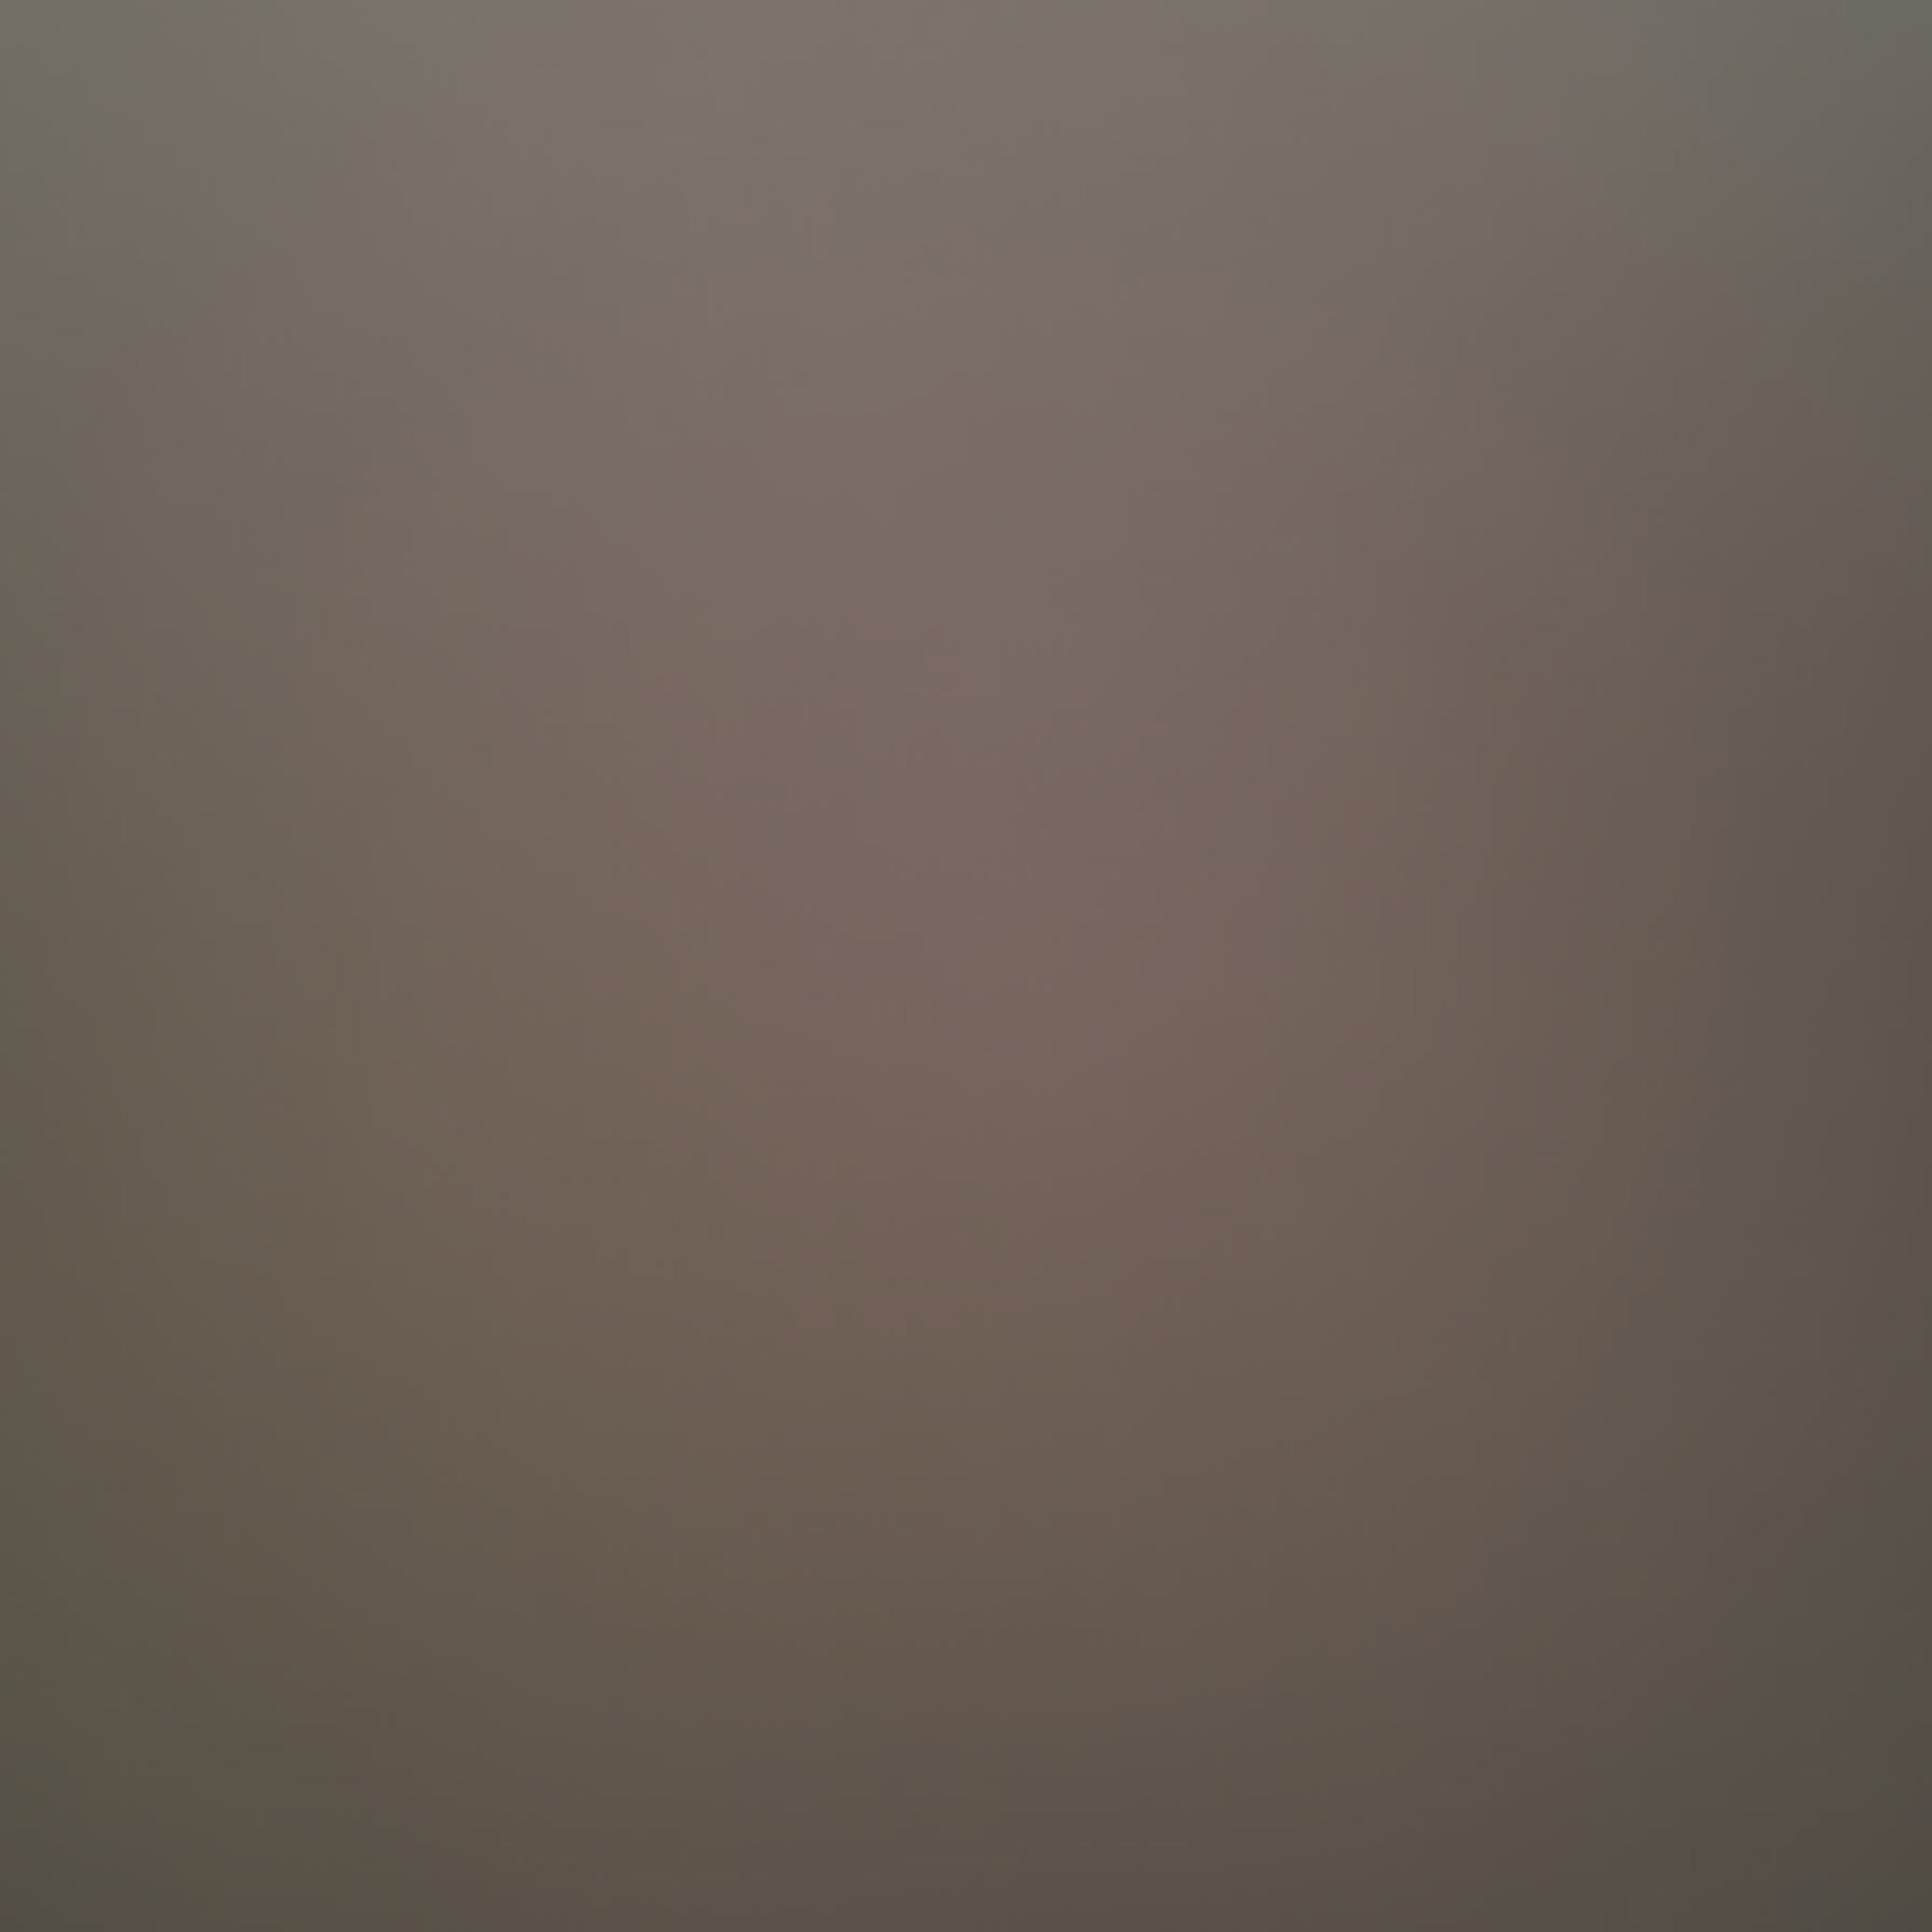

In [5]:
if TRAIN_MEAN_IMG_FILE.exists():
    train_mean_img = torch.load(TRAIN_MEAN_IMG_FILE)
else:
    train_dataset = my_data.datasets['train']
    train_mean_img = get_data_mean_img(train_dataset.data)
    torch.save(train_mean_img, TRAIN_MEAN_IMG_FILE)

from multimodal.attention_maps import n_inv
plt.imshow(n_inv(train_mean_img).permute((1, 2, 0)).numpy())
plt.axis('off')
output_fig('Train Mean Image')

train_mean_img = train_mean_img.to(device)
zero_img = torch.zeros(3, IMAGE_H, IMAGE_W, dtype=torch.float, device=device)


def prepend_image_placeholder_for_batch(model, x):
    x = x.to(device=device)
    x = x.unsqueeze(0)
    if isinstance(model, MultiModalLitModel) and (
            model.language_model.text_encoder.captioning or
            model.language_model.text_encoder.has_attention):
        image_features, image_feature_map = model.model.encode_image(x)
        image_features = image_features.squeeze(0)
        image_feature_map = image_feature_map.squeeze(0)
    else:
        image_features, image_feature_map = None, None

    def _fn(batch):
        y, y_len, raw_y = batch
        batch_size = len(y)
        batch = {
            'y': y,
            'y_len': y_len,
        }
        if image_features is not None:
            batch['image_features'] = image_features.expand(*([batch_size] + [-1] * image_features.dim()))
        if image_feature_map is not None:
            batch['image_feature_map'] = image_feature_map.expand(*([batch_size] + [-1] * image_feature_map.dim()))
        return batch

    return _fn

In [6]:
loss_dfs = {
    data_name: pd.DataFrame(np.zeros((len(dataset), 0)))
    for data_name, dataset in datasets.items()
}


my_model_format = ({'saycam': 'SAYCam-S', 'childes': 'CHILDES-Sarah'}[dataset_name] + ' {}').format

my_groups = {my_model_format(name): list(map(my_model_format, group)) for name, group in groups.items()}

for model_name, model in ori_models.items():
    print(f'running {model_name} ...')
    my_model_name = my_model_format(model_name)
    for data_name, dataset in datasets.items():
        if not dataset:
            continue
        dataloader = DataLoader(
            dataset,
            collate_fn=collate_fn,
            shuffle=False,
            batch_size=my_batch_size,
            drop_last=False,
        )
        batches = map(prepend_image_placeholder_for_batch(model, train_mean_img), dataloader)
        losses = get_model_losses_on_batches(model, batches)
        losses = losses.cpu().numpy()
        loss_dfs[data_name][my_model_name] = losses

for probing_results_dir in Path('/misc/vlgscratch4/LakeGroup/wentao/BabyBERTa/probing_results/babyberta').glob('*'):
    model_name = probing_results_dir.name
    if model_name not in ['BabyBERTa_AO-CHILDES', 'BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1'][:1]:
        continue
    name_, _, dataset_ = model_name.partition('_')
    model_name = dataset_ + ' ' + 'Transformer'
    my_groups[model_name] = [model_name]
    for file in probing_results_dir.glob('*'):
        paradigm_name = file.stem
        data_name = get_data_name_from_paradigm_name(paradigm_name)
        sentences, losses = zip(*read_sentences_and_losses(file))
        loss_dfs[data_name][model_name] = losses

running LSTM 0 ...


In [7]:
def get_common_substr_len(strs, index_fn=lambda l: l):
    l = 0
    l_last_space = -1
    while True:
        try:
            c = None
            for s in strs:
                cur_c = s[index_fn(l)]
                if c is None:
                    c = cur_c
                assert c == cur_c
        except (IndexError, AssertionError):
            break
        if c == ' ':
            l_last_space = l
        l += 1
    return l_last_space + 1


def get_sentence_pair_str(sentence_pair):
    strs = list(map(str, sentence_pair))
    prefix_len = get_common_substr_len(strs)
    suffix_len = get_common_substr_len(strs, lambda l: -l-1)
    return strs[0][:prefix_len] + '(' + '/'.join(reversed([s[prefix_len:-suffix_len] for s in strs])) + ')' + strs[0][-suffix_len:]


def get_sentence_pair_example(sentence_pairs, sample_n=0):
    if sample_n:
        samples = sentence_pairs.sample(n=sample_n)
        for sample in samples:
            print(get_sentence_pair_str(sample))
    return min(map(get_sentence_pair_str, sentence_pairs), key=len)


data_examples = {}
for data_name, sentences in zorro_data.items():
    print(f'{data_name}:')
    sentence_pairs = pd.Series(paired(sentences))[filter_masks[data_name]]
    if len(sentence_pairs):
        example_str = get_sentence_pair_example(sentence_pairs)

        # remove the space before the last punctuation
        if example_str[-2] == ' ':
            example_str = example_str[:-2] + example_str[-1:]

        data_examples[data_name] = example_str

phenomenon_examples = defaultdict(list)
for data_name, example_str in data_examples.items():
    phenomenon_examples[data_name[0]].append(example_str)
phenomenon_examples = {phenomenon: min(examples, key=len) for phenomenon, examples in phenomenon_examples.items()}

('determiner-noun agreement', 'across 1 adjective'):
('determiner-noun agreement', 'between neighbors'):
('subject-verb agreement', 'across prepositional phrase'):
('subject-verb agreement', 'across relative clause'):
('subject-verb agreement', 'in question with aux'):
('subject-verb agreement', 'in simple question'):
('anaphor agreement', 'pronoun gender'):
('argument structure', 'dropped argument'):
('argument structure', 'swapped arguments'):
('argument structure', 'transitive'):
('binding', 'principle a'):
('case', 'subjective pronoun'):
('ellipsis', 'n bar'):
('filler-gap', 'wh question object'):
('filler-gap', 'wh question subject'):
('irregular', 'verb'):
('island-effects', 'adjunct island'):
('island-effects', 'coordinate structure constraint'):
('local attractor', 'in question with aux'):
('npi licensing', 'matrix question'):
('npi licensing', 'only npi licensor'):
('quantifiers', 'existential there'):
('quantifiers', 'superlative'):


CHILDES-Sarah LSTM 0  AO-CHILDES Transformer
phenomenon                paradigm                                                                     
argument structure        dropped argument                             0.865229                0.823450
                          swapped arguments                            0.817669                0.983083
                          transitive                                   0.594415                0.660904
binding                   principle a                                  0.679739                0.986928
case                      subjective pronoun                           0.738819                0.932021
determiner-noun agreement across 1 adjective                           0.574561                0.921053
                          between neighbors                            0.668478                0.959783
ellipsis                  n bar                                        0.373134                0.507463
filler-gap                wh question object                           0.450000                0.988889
                          wh question subject                          0.906024                0.886747
irregular                 verb                                         0.641509                0.752358
island-effects            adjunct island                               0.355556                0.450794
                          coordinate structure constraint              0.482692                0.938462
local attractor           in question with aux                         0.798479                0.980989
npi licensing             matrix question                              0.690289                0.849081
                          only npi licensor                            0.221374                0.841603
quantifiers               existential there                            0.772059                0.935049
                          superlative                                  0.909396                0.932886
subject-verb agreement    across prepositional phrase                  0.538750                0.741250
                          across relative clause                       0.576823                0.740885
                          in question with aux                         0.555556                0.897363
                          in simple question                           0.551786                0.957143

,CHILDES-Sarah LSTM 0,AO-CHILDES Transformer
phenomenon,,
argument structure,0.759104,0.822479
binding,0.679739,0.986928
case,0.738819,0.932021
determiner-noun agreement,0.621520,0.940418
ellipsis,0.373134,0.507463
filler-gap,0.678012,0.937818
irregular,0.641509,0.752358
island-effects,0.419124,0.694628
local attractor,0.798479,0.980989


CHILDES-Sarah LSTM 0      0.625561
AO-CHILDES Transformer    0.848554
dtype: float64

,phenomenon,paradigm,idx,model,accuracy,phenomenon paradigm
0,determiner-noun agreement,across 1 adjective,0,CHILDES-Sarah LSTM 0,1.0,determiner-noun agreement\nacross 1 adjective
1,determiner-noun agreement,across 1 adjective,1,CHILDES-Sarah LSTM 0,1.0,determiner-noun agreement\nacross 1 adjective
2,determiner-noun agreement,across 1 adjective,2,CHILDES-Sarah LSTM 0,1.0,determiner-noun agreement\nacross 1 adjective
3,determiner-noun agreement,across 1 adjective,3,CHILDES-Sarah LSTM 0,1.0,determiner-noun agreement\nacross 1 adjective
4,determiner-noun agreement,across 1 adjective,4,CHILDES-Sarah LSTM 0,1.0,determiner-noun agreement\nacross 1 adjective
...,...,...,...,...,...,...
27619,quantifiers,superlative,1980,AO-CHILDES Transformer,1.0,quantifiers\nsuperlative
27620,quantifiers,superlative,1981,AO-CHILDES Transformer,1.0,quantifiers\nsuperlative
27621,quantifiers,superlative,1988,AO-CHILDES Transformer,1.0,quantifiers\nsuperlative
27622,quantifiers,superlative,1993,AO-CHILDES Transformer,1.0,quantifiers\nsuperlative


/home/ww2135/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


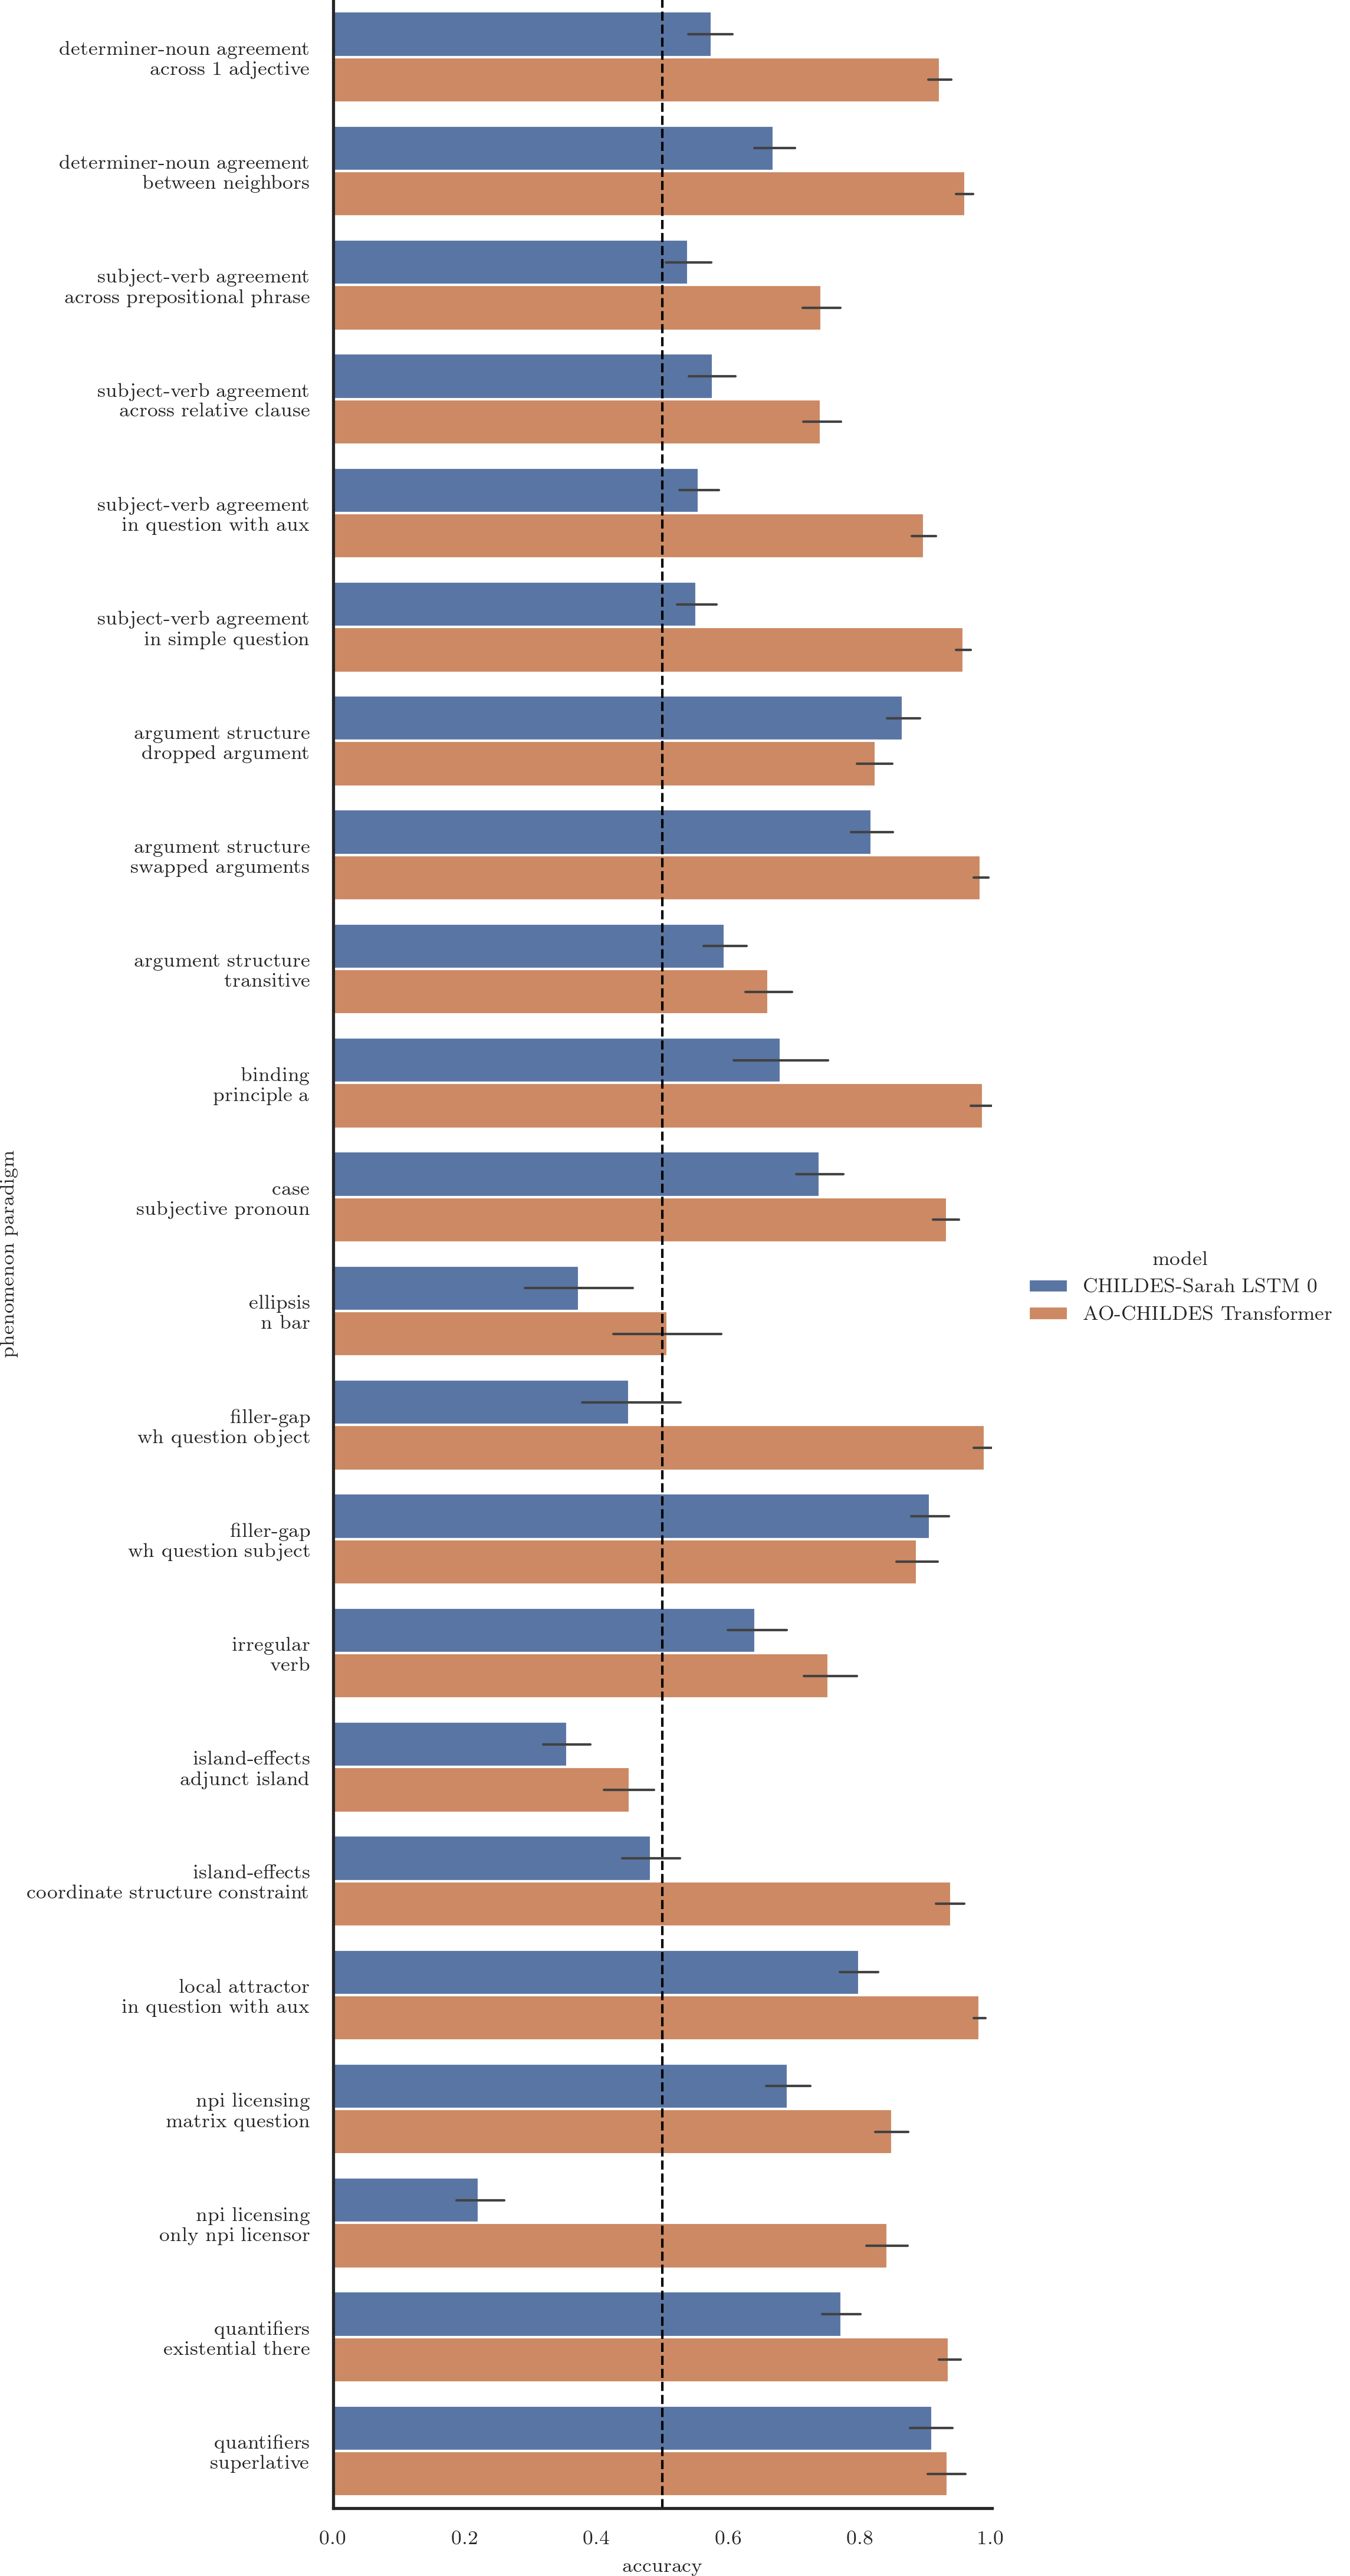

/home/ww2135/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


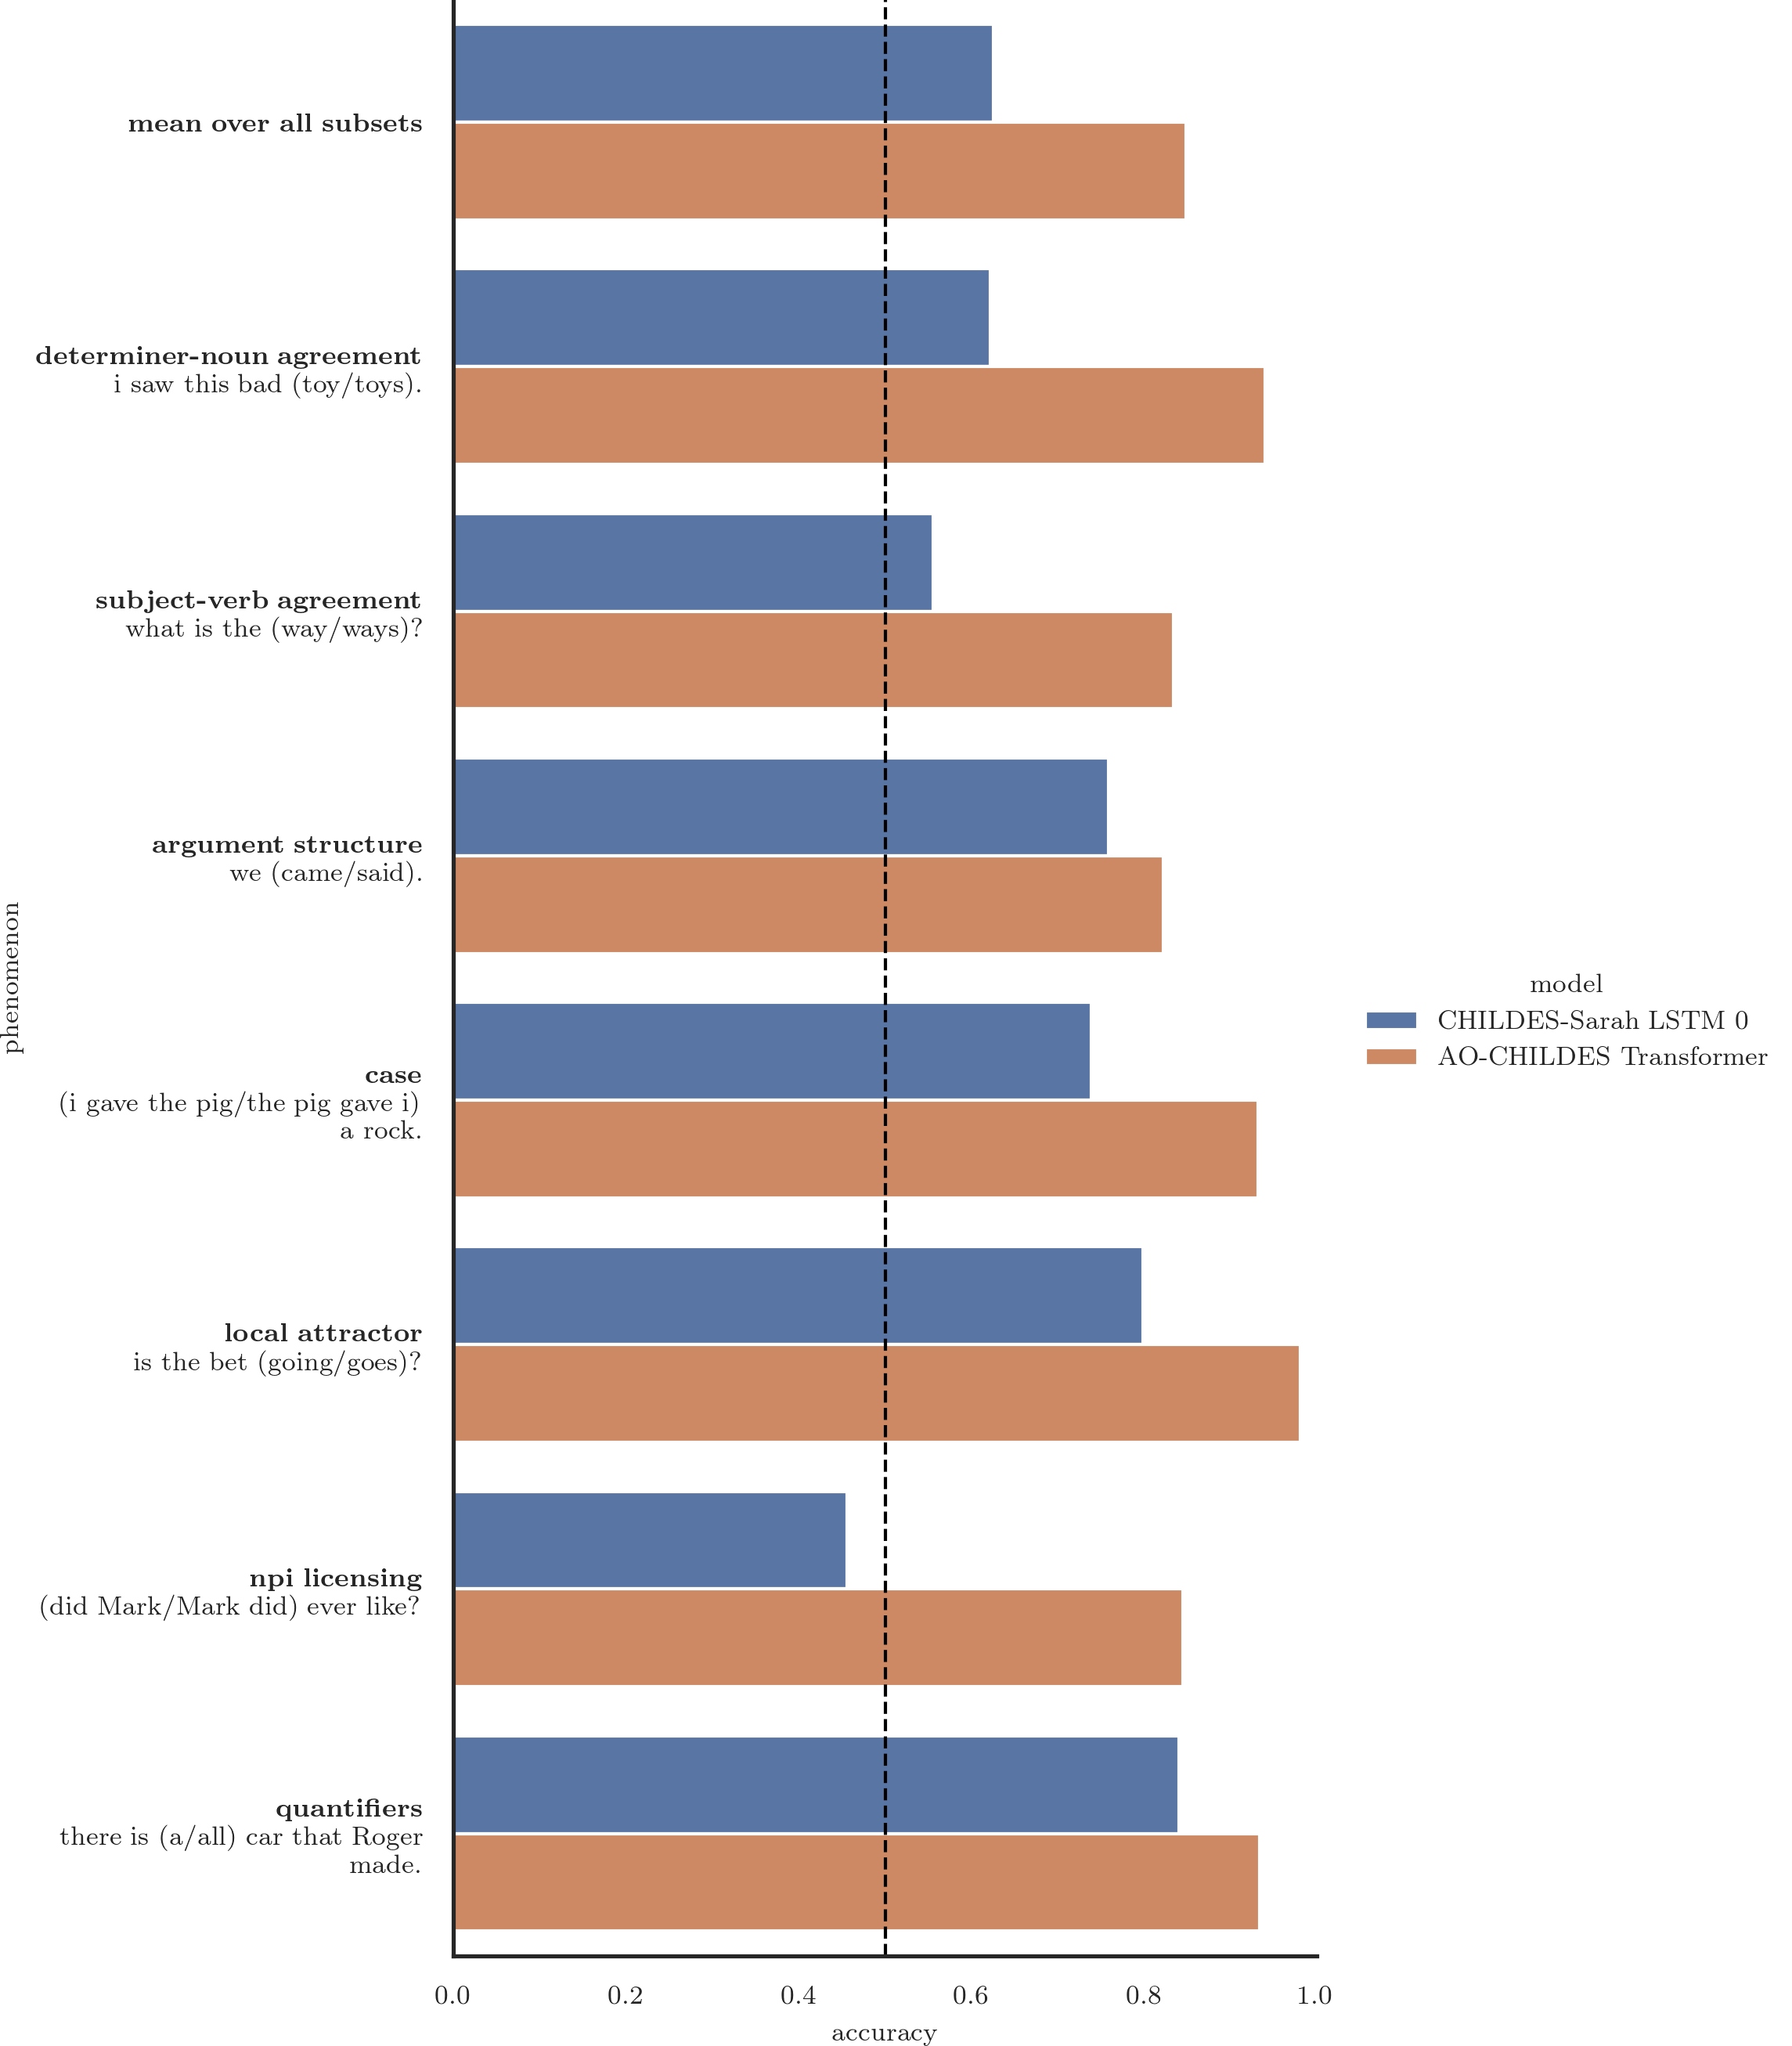

/home/ww2135/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


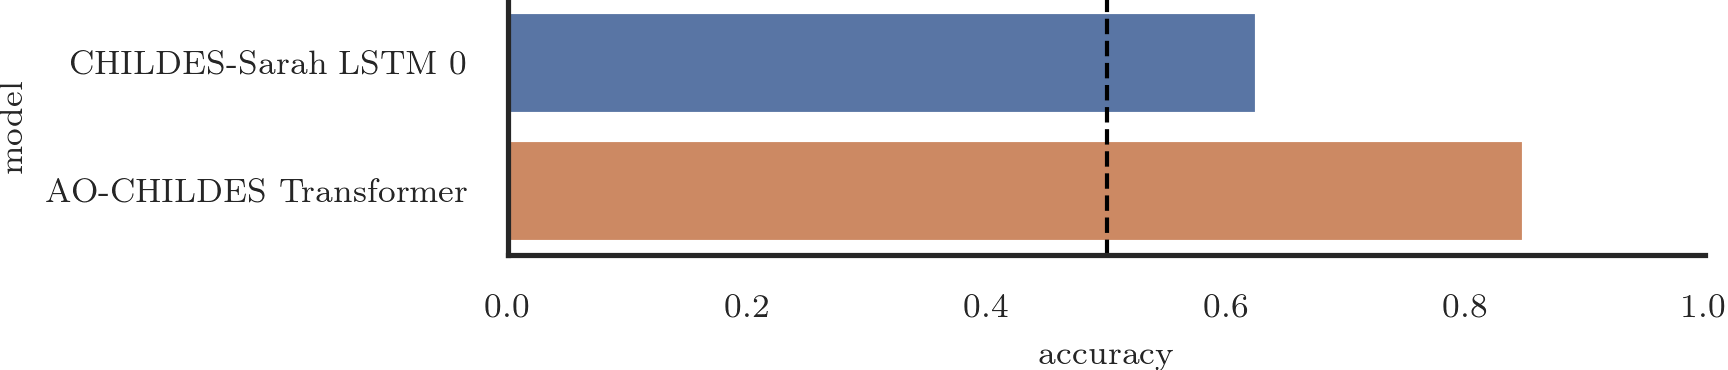

In [8]:
fontsize = 8
context = {
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.title_fontsize': fontsize,
}
width = 6.0
height_each = 0.65
height_base = 0.5


random_accuracy = 0.5
sep = '\n'


def get_correct_df(loss_df):
    sub_loss_dfs = [loss_df.iloc[i::2].reset_index(drop=True) for i in range(2)]
    return sub_loss_dfs[0] > sub_loss_dfs[1]


correct_dfs = {
    data_name: get_correct_df(loss_df)
    for data_name, loss_df in loss_dfs.items()
}

filtered_correct_dfs = {
    data_name: correct_df[filter_masks[data_name]]
    for data_name, correct_df in correct_dfs.items()
}


for current_correct_dfs in [correct_dfs, filtered_correct_dfs][1:]:
    data_names = list(current_correct_dfs.keys())

    ori_example_df = pd.concat(
        [current_correct_dfs[data_name] for data_name in data_names],
        keys=data_names,
        names=['phenomenon', 'paradigm', 'idx'],
    )
    exclude_models = [my_model_format("Captioning LSTM"), my_model_format("CBOW")][:0]
    example_df = pd.DataFrame({name: ori_example_df[group].mean(axis=1) for name, group in my_groups.items() if name not in exclude_models})
    phenomenon_agg_name = 'mean over all subsets'
    phenomenon_order = [
        phenomenon_agg_name,
        'determiner-noun agreement',
        'subject-verb agreement',
        'argument structure',
        'case',
        'local attractor',
        'npi licensing',
        'quantifiers',
    ]
    model_order = [
        my_model_format('unigram'),
        my_model_format('bigram'),
        my_model_format('CBOW'),
        my_model_format('LSTM'),
        my_model_format('Captioning LSTM'),
        'AO-CHILDES Transformer',
    ]
    if dataset_name == "childes":
        model_order = [my_model_format('LSTM 0')] + model_order[-1:]
    model_order = [name for name in model_order if name not in exclude_models]

    example_long_df = example_df.reset_index().melt(
        id_vars=['phenomenon', 'paradigm', 'idx'], var_name='model', value_name='accuracy')
    example_long_df['phenomenon paradigm'] = example_long_df['phenomenon'] + sep + example_long_df['paradigm']

    phenomenon_paradigm_df = example_df.groupby(level=['phenomenon', 'paradigm']).mean()
    display(phenomenon_paradigm_df)
    phenomenon_paradigm_long_df = phenomenon_paradigm_df.reset_index().melt(
        id_vars=['phenomenon', 'paradigm'], var_name='model', value_name='accuracy')

    phenomenon_df = phenomenon_paradigm_df.groupby(by=['phenomenon']).mean()
    display(phenomenon_df)

    df = phenomenon_paradigm_df.mean(axis=0)
    display(df)

    with plt.rc_context(context):
        display(example_long_df)
        height = height_base + height_each * len(example_long_df['phenomenon paradigm'].unique())
        g = sns.catplot(
            kind="bar", data=example_long_df, x='accuracy', y='phenomenon paradigm', hue='model',
            hue_order=model_order, errwidth=1,
            height=height, aspect=width/height,
        )
        #g.figure.set_size_inches(7, 8)
        g.ax.set_xlim(right=1)
        g.refline(x=random_accuracy, linestyle='dashed', linewidth=1, color='black')
        output_fig('Syntactic Probing Accuracy on Paradigms')

        phenomenon_paradigm_long_df_ = phenomenon_paradigm_long_df.copy()
        phenomenon_paradigm_long_df_['phenomenon'] = phenomenon_agg_name
        phenomenon_paradigm_long_df_ = pd.concat(
            [phenomenon_paradigm_long_df.copy(), phenomenon_paradigm_long_df_],
            ignore_index=True,
        )
        def _bf(text):
            return ' '.join((r'\textbf{' + piece + r'}' for piece in text.split(' ')))
        def _get_phenomenon_label(phenomenon):
            label = _bf(phenomenon)
            if phenomenon != phenomenon_agg_name:
                label += '\n' + textwrap.fill(phenomenon_examples[phenomenon], width=32)
            return label
        phenomenon_paradigm_long_df_['phenomenon'] = phenomenon_paradigm_long_df_['phenomenon'].map(_get_phenomenon_label)
        phenomenon_order_ = list(map(_get_phenomenon_label, phenomenon_order))
        height = height_base + height_each * len(phenomenon_paradigm_long_df_['phenomenon'].unique())
        g = sns.catplot(
            kind="bar", data=phenomenon_paradigm_long_df_, x='accuracy', y='phenomenon', hue='model',
            order=phenomenon_order_, hue_order=model_order, errorbar=None,
            height=height, aspect=width/height,
        )
        g.ax.set_xlim(right=1)
        g.refline(x=random_accuracy, linestyle='dashed', linewidth=1, color='black')
        output_fig('Syntactic Probing Accuracy Mean on Phenomena Over Paradigms')

        height = height_base + 1.5 * height_each
        g = sns.catplot(
            kind="bar", data=phenomenon_paradigm_long_df, x='accuracy', y='model',
            order=model_order, errorbar=None,
            height=height, aspect=width/height,
        )
        g.ax.set_xlim(right=1)
        g.refline(x=random_accuracy, linestyle='dashed', linewidth=1, color='black')
        output_fig('Syntactic Probing Accuracy Mean Over Paradigms')

    if dataset_name == "childes":
        target_model = my_model_format("LSTM 0")
        ori_target_model = my_model_format("LSTM 0")
        baseline_models = []
        ori_baseline_models = []
    else:
        target_model = my_model_format("LSTM")
        ori_target_model = my_model_format("LSTM 0")
        baseline_models = [my_model_format("unigram"), my_model_format("bigram"), my_model_format("CBOW")]
        ori_baseline_models = [my_model_format("1-gram"), my_model_format("2-gram"), my_model_format("CBOW 0")]
    displayed_models = [ori_target_model] + ori_baseline_models

    for data_name in phenomenon_paradigm_df.index:
        model_mean_series = phenomenon_paradigm_df.loc[data_name]
        target_model_accuracy = model_mean_series[target_model]
        baseline_accuracy = model_mean_series[baseline_models].max()
        if target_model_accuracy >= 0.52 and target_model_accuracy > baseline_accuracy + 0.03:
            sentence_pairs = pd.Series(paired(zorro_data[data_name]))
            sentence_pairs = sentence_pairs[filter_masks[data_name]]
            correct_df = current_correct_dfs[data_name]
            print(f'comparing {data_name} ({frac_format(len(sentence_pairs), len(zorro_data[data_name]) / 2)}):')
            display(model_mean_series)
            for sentence_pair, (idx, corrects) in zip(sentence_pairs, correct_df.iterrows()):
                if corrects[ori_target_model] and not all(corrects[ori_baseline_models]):
                    for sentence in sentence_pair:
                        print(' '.join(map(str, sentence)))
                    display(corrects[displayed_models])